In [1]:
import sys
sys.path.append('..\\helpers')

import cv2
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from loguru import logger
import pandas as pd
import seaborn as sns
from PIL import Image, ImageDraw
from functools import reduce

from pywt import dwt2
import math
from scipy import ndimage


# From helpers directory
from preprocessing import Preprocessor
from morphological_sifter import MorphologicalSifter

import display


preprocessor = Preprocessor()
mms = MorphologicalSifter()

plt.rcParams['figure.figsize'] = (20, 18)
plt.style.use('classic')
plt.subplots_adjust(wspace=0, hspace=0)
sns.set()

# To allow auto reload to this notebook after modifying any external file imported
%load_ext autoreload
%autoreload 2

<Figure size 640x480 with 0 Axes>

## Exploratory Data Analysis

Understanding data structure and setting global variables

In [2]:
dataset_folder_paths = [(x[0].split("\\")[-1], x[0]) for x in os.walk("..\\dataset")][1:]
dataset_folder_paths

[('groundtruth', '..\\dataset\\groundtruth'),
 ('images', '..\\dataset\\images'),
 ('masks', '..\\dataset\\masks'),
 ('overlay', '..\\dataset\\overlay'),
 ('processed', '..\\dataset\\processed'),
 ('images', '..\\dataset\\processed\\images'),
 ('overlay', '..\\dataset\\processed\\overlay')]

Preparing a dataframe to summarize the dataset

In [3]:
positive_labelled_images = []
negative_labelled_images = []

dataset = []

labels = ["positives", "negatives"]

for idx, object in enumerate(labels):
        with open(f'..\\dataset\\{str(object)}.txt') as f:
            lines = f.read().splitlines()
            
            for line in lines:
                if line != "":
                    new_path = os.path.join(dataset_folder_paths[1][1], line)
                    dataset.append((str(object), line))
                    positive_labelled_images.append(new_path) if str(object) == 'positives' else negative_labelled_images.append(new_path)

dataset_df = pd.DataFrame(dataset, columns=['class', 'filename'])
dataset_df.sample(10)

,class,filename
277,negatives,50996083_71c1a60d57c5322f_MG_R_ML_ANON.tif
259,negatives,50994381_cc9e66c5b31baab8_MG_L_CC_ANON.tif
95,positives,51049107_8c105bb715bf1c3c_MG_L_CC_ANON.tif
227,negatives,26933830_f8bfddc28e8045c0_MG_R_ML_ANON.tif
63,positives,24055445_ac3185e18ffdc7b6_MG_L_ML_ANON.tif
332,negatives,50999148_cb65e8dac169f596_MG_L_CC_ANON.tif
330,negatives,50999094_cb65e8dac169f596_MG_L_ML_ANON.tif
383,negatives,53582567_3e73f1c0670cfb0a_MG_R_CC_ANON.tif
294,negatives,50997053_ce5e5e18a261cd29_MG_L_CC_ANON.tif
400,negatives,53587131_7b71aa9928e6975e_MG_L_CC_ANON.tif


Dataset Summary

In [4]:
dataset_df.describe()

,class,filename
count,410,410
unique,2,410
top,negatives,20586908_6c613a14b80a8591_MG_R_CC_ANON.tif
freq,303,1


In [5]:
# Checking if we have duplicate files, all good!
len(dataset_df["filename"].unique())

410

<Axes: >

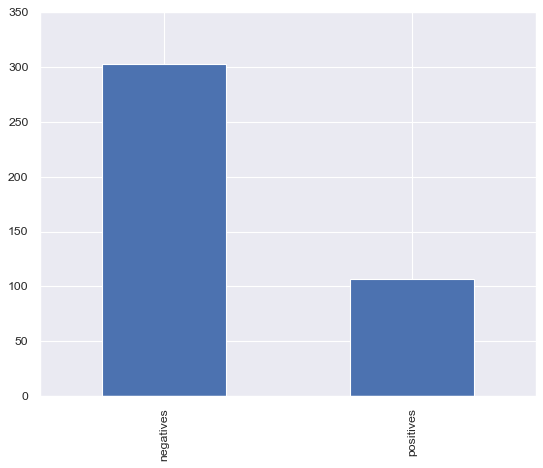

In [6]:
# balanced classes
dataset_df['class'].value_counts().plot(kind='bar')

Visualizing the dataset

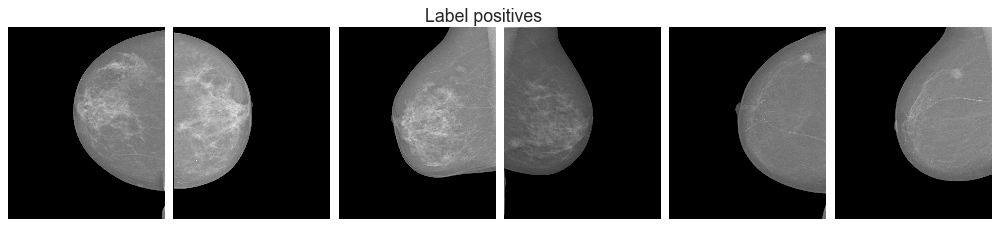

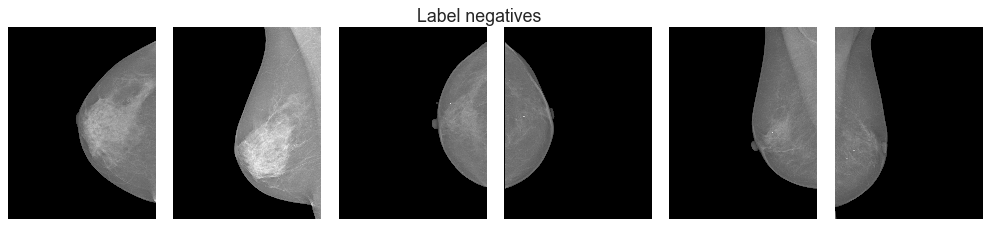

In [7]:
for idx, lbl in enumerate(labels):
    nrows, ncols = 1, 6
    fig, ax = plt.subplots(nrows, ncols, figsize=(16, 3))
    plt.subplots_adjust(wspace=0, hspace=1)

    for idx, fname in enumerate(dataset_df.loc[dataset_df['class'] == lbl]['filename'][:ncols]):
        img = Image.open(os.path.join(dataset_folder_paths[1][1],fname))
        plt.subplot(nrows, ncols, idx+1)
        plt.imshow(np.array(img), cmap='gray')
        fig.suptitle(f'Label {lbl}', fontsize=16)
        plt.axis('off')


## Pre-processing

Pre-processing steps:
1. Image rescaling by a factor of 4
2. The breast profile is pre-segmented using a simple threshold and then the redundant background is cropped away in the dataset.
3. The pixel values in the image are linearly rescaled to 16-bit
4. Contrast limited adaptive histogram equalization (CLAHE) is then applied. The number of tiles in CLAHE is set as {4, 4}, which is arbitrarily chosen, and the contrast enhancement limit is set as 0.01 (default).

Those processes are done firstly on a single image for testing purpsose before modifying the original dataset.

In [8]:
# All of the above is now implemented in a separate class and can be applied using the following line of code
preprocessor.fit(dataset_path=dataset_folder_paths[1][1], 
#                  process_n=1, 
                 plot=False, 
                 export_processed=True)

2023-05-04 20:01:49.394 | INFO     | preprocessing:fit:83 - Started processing pipeline.
100%|█████████████████████████| 410/410 [02:07<00:00,  3.22it/s]
2023-05-04 20:03:56.956 | INFO     | preprocessing:fit:130 - Finished processing 410 files in approximately 127.562 seconds.


## Region Candidate Generation

Two stages were proposed:
1. Multi-scale morphological shifters
2. Multi-level Otsu thresholding

1. Multi-scale Morphological Sifters

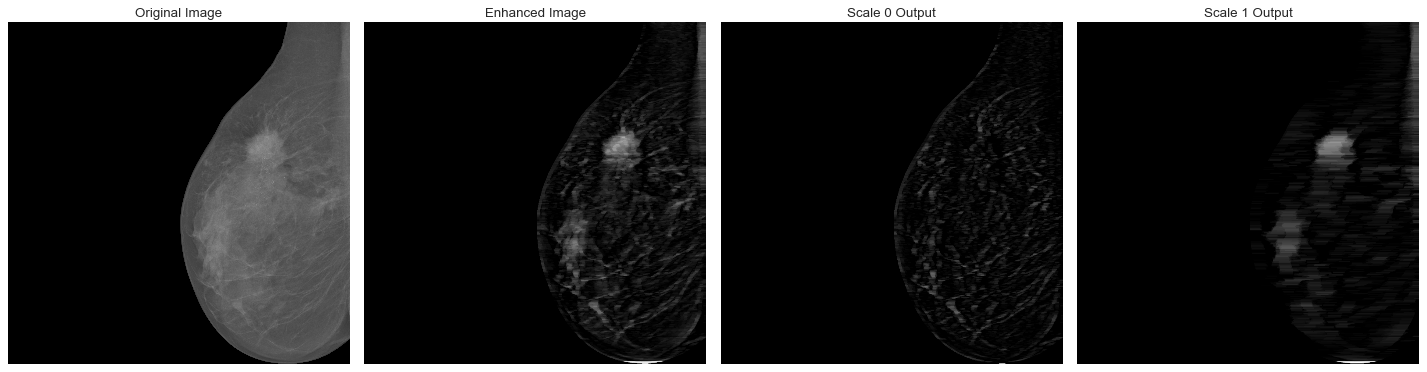

In [18]:
# image_input_name = '20587612_f4b2d377f43ba0bd_MG_R_CC_ANON.tif'
# image_input_name = '22670278_98429c0bdf78c0c7_MG_R_CC_ANON.tif'
image_input_name = '22613822_45c7f44839fd9e68_MG_R_ML_ANON.tif'
# image_input_name = '53586869_6ac23356b912ee9b_MG_L_ML_ANON.tif'

normalized_image, enhanced_images, LSE_magnitudes = mms.fit(
    image_input_name, 
    plot=True,
)

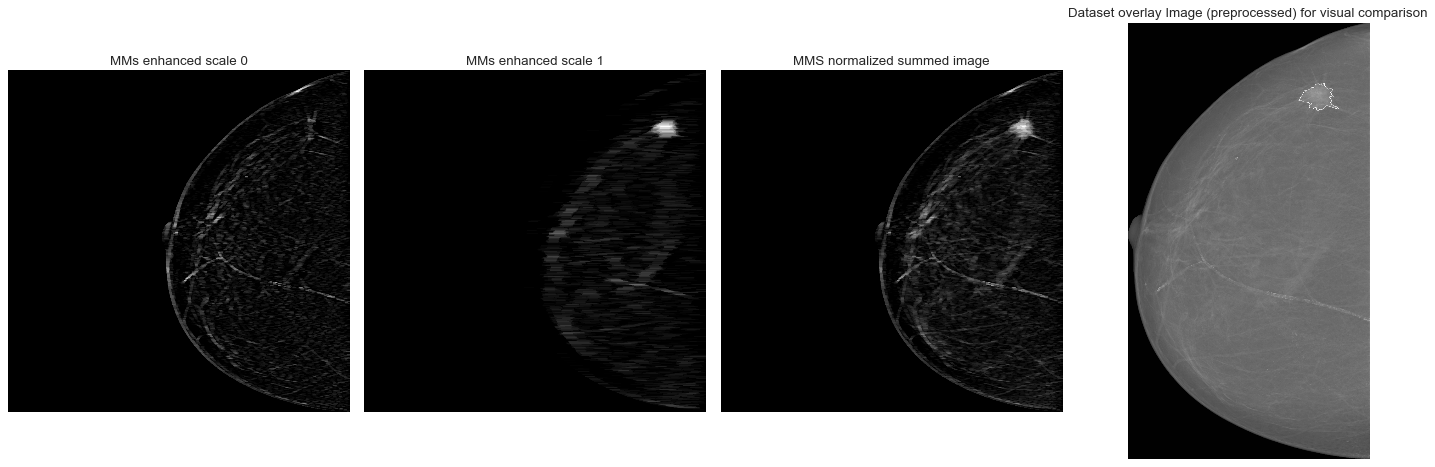

In [13]:
# Reading the same processed image (ovarlayed version) for visual comparison
overlay_image_dataset = os.path.join(mms.overlay_dir, image_input_name)
overlay_image = cv2.imread(overlay_image_dataset)

# Display the enhanced and tophat image
imgs = {
    "MMs enhanced scale 0": enhanced_images[0],
    "MMs enhanced scale 1": enhanced_images[1],
    "MMS normalized summed image": normalized_image,
    "Dataset overlay Image (preprocessed) for visual comparison": overlay_image
}
display.plot_figures(imgs, 1, 4)

# Instead of MLO Thresholding
# superpixels - non-parametric approach
# k means clusturing - K levels
# means clusturing - reguarization params


# Features extraction
# GLCM features 10-15 + statistics of mass region (contrast average value)

# Shape features 10
# LBP 
# SIFTs

# Gabor wavelets ~ good to charectirize textures in iris


# Features reduction - LDA 